# NSGA3 Algorithm

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Reference directions
For demonstration purposes, shown are the reference directions used by the NSGA3 algorithm to maintain a diverse non-dominated front. These vectors are generated automatically when instantiating the NSGA3 algorithm. When selecting individuals for the next generation, NSGA3 finds solutions that are closest to under-represented reference directions.

In [16]:
from gatf.population import uniform_reference_points

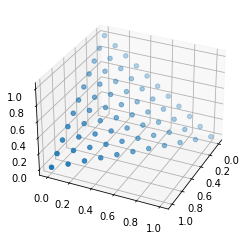

In [17]:
ref_points = uniform_reference_points(3,10)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(ref_points[:,0], ref_points[:,1], ref_points[:,2])
ax.view_init(30, 25)

## ZDT2 function
### Define the objective
Our first objective is the ZDT2 function. This is a 30-dimensional problem with a non-convex pareto front.

In [18]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None,None], dtype=tf.float64),)) 
def ZDT2(X):
    g = tf.reshape(1.0 + (9.0/(tf.cast(tf.shape(X)[1],tf.float64) - 1.0)) * tf.reduce_sum(X[:,1:], axis=1), (-1,1))
    f1 = tf.reshape(X[:,0], (-1,1))
    f2 = g * (1.0 - (f1 / g)**2)
    return tf.concat([f1,f2],axis=1)

### Perform the optimization
Here we'll begin the optimizer. Hyperparameters such as the population size, generations, crossover and mutation probabilities may need to be tuned to your particular application.

In [19]:
from gatf import NSGA3

In [20]:
# Instantiate the optimizer
nsga = NSGA3(ZDT2,
             n_variables = 30,
             n_objectives = 2,
             population_size = 92,
             tournament_size = 5,
             generations = 3000,
             lowerbound = 0.0,
             upperbound = 1.0,
             mutation_prob = 0.1,
             crossover_prob = 0.9,
             record_gens = 50,
             mutation_eta = 30.0,
             crossover_eta = 10.0
            )

Population size: 92, reference directions: 88, partitions: 87


In [21]:
# Go!
res = nsga()

Generation 3000 – MDR 0.04 – Ref dirs 64.0%     
Complete – non-dominated front size: 92


### Plotting results
Let's plot the final population distributed on the pareto front of the function.

(-0.03400067670650153, 1.0508955829016213)

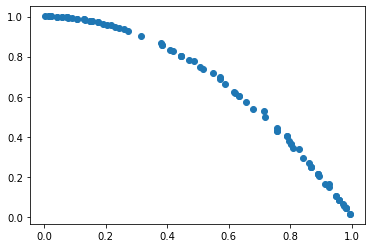

In [22]:
# Get results to plot
F = res['fitness']

fig,ax = plt.subplots()
ax.scatter(F[:,0],F[:,1])
xlim,ylim = ax.get_xlim(),ax.get_ylim()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

### Plotting statistics
Now let's look at some statistics. The mutual domination rate compares the current with the former generation. Values greater than one indicate an improvement while values less than one indicate that the current population at each generation is partially dominated by the previous. If zero, then there is no improvement, suggesting that the true pareto front has been reached. The % filled reference directions give an indication of the diversity of the solutions, with larger values indicating greater diversity.

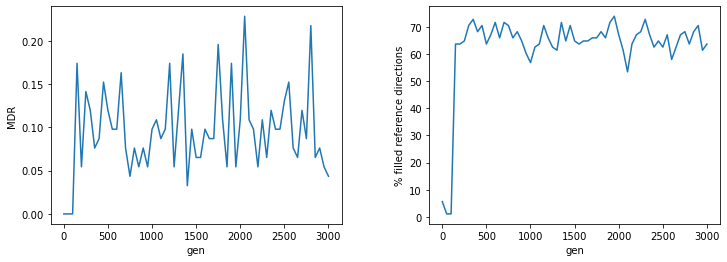

In [23]:
# Get results to plot
stats = res['statistics']

gen = np.array(stats['gen'])
mdr = np.array(stats['mdr'])
refs = 100 * np.array(stats['refs'])

fig,ax = plt.subplots(1,2, figsize=[12,4])

ax[0].plot(gen, mdr, label = 'mdr')
ax[0].set_xlabel('gen')
ax[0].set_ylabel('MDR')

ax[1].plot(gen, refs, label = 'filled references')
ax[1].set_xlabel('gen')
ax[1].set_ylabel('% filled reference directions')

plt.subplots_adjust(wspace = 0.3)

## ZDT3 function
### Define the objective
Now let's try the ZDT3 function. This is a 30-dimensional problem with multiple disconnected pareto fronts.

In [24]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None,None], dtype=tf.float64),)) 
def ZDT3(X):
    g = tf.reshape(1.0 + (9.0/(tf.cast(tf.shape(X)[1],tf.float64) - 1.0)) * tf.reduce_sum(X[:,1:], axis=1), (-1,1))
    f1 = tf.reshape(X[:,0], (-1,1))
    h = tf.reshape(1.0 - tf.sqrt(f1 / g) - (f1 / g) * tf.math.sin(10.0 * np.pi * f1), (-1,1))
    f2 = g * h
    return tf.concat([f1,f2],axis=1)

x,y = np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
x = x.reshape((-1,1))
y = y.reshape((-1,1))
P = ZDT3(np.hstack([x,y]))

### Perform the optimization
Here we'll begin the optimizer. Hyperparameters such as the population size, generations, crossover and mutation probabilities may need to be tuned to your particular application.

In [25]:
# Instantiate the optimizer
nsga = NSGA3(ZDT3,
             n_variables = 30,
             n_objectives = 2,
             population_size = 92,
             tournament_size = 5,
             generations = 3000,
             lowerbound = 0.0,
             upperbound = 1.0,
             mutation_prob = 0.3,
             crossover_prob = 0.7,
             record_gens = 50,
             mutation_eta = 30.0,
             crossover_eta = 30.0
            )

Population size: 92, reference directions: 88, partitions: 87


In [26]:
# Go!
res = nsga()

Generation 3000 – MDR 0.07 – Ref dirs 42.0%     
Complete – non-dominated front size: 92


### Plotting results
Let's plot the final population distributed on the pareto front of the function.

(-0.8226924820149453, 0.95989684364452)

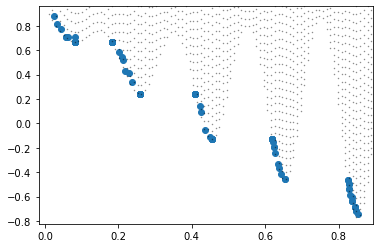

In [27]:
# Get results to plot
F = res['fitness']

fig,ax = plt.subplots()
ax.scatter(F[:,0],F[:,1])
xlim,ylim = ax.get_xlim(),ax.get_ylim()
ax.scatter(P[:,0],P[:,1], c='k', s=0.2, alpha = 0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

### Plotting statistics
And now some statistics. The positive MDR throughout suggests that continuous improvements were being made. Running the algorithm for more generations or tuning the hyperparameters may give a better result.

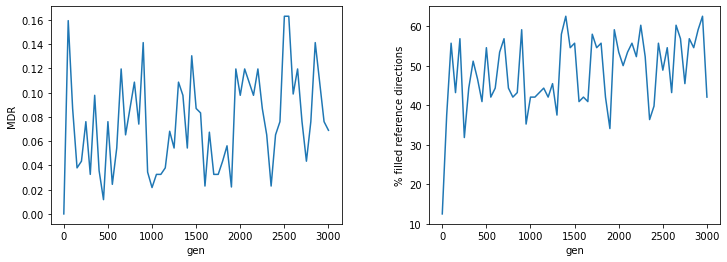

In [28]:
# Get results to plot
stats = res['statistics']

gen = np.array(stats['gen'])
mdr = np.array(stats['mdr'])
refs = 100 * np.array(stats['refs'])

fig,ax = plt.subplots(1,2, figsize=[12,4])

ax[0].plot(gen, mdr, label = 'mdr')
ax[0].set_xlabel('gen')
ax[0].set_ylabel('MDR')

ax[1].plot(gen, refs, label = 'filled references')
ax[1].set_xlabel('gen')
ax[1].set_ylabel('% filled reference directions')

plt.subplots_adjust(wspace = 0.3)